In [1]:
from wgan import WGAN
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
from functools import partial
from NuRadioReco.utilities import fft
from NuRadioReco.utilities import units
from NuRadioReco.framework import base_trace
import sys
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing
import analyze

2022-09-27 10:42:08.196488: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 10:42:08.358828: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-27 10:42:08.358849: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-27 10:42:08.393361: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-27 10:42:08.989994: W tensorflow/stream_executor/pla

# Data

In [2]:
data = np.load('/lustre/fs22/group/radio/dhjelm/data_preprocessed.npy')
current_noise = np.load('current_noise.npy')


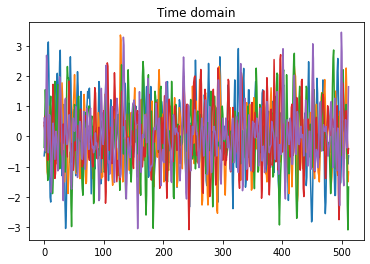

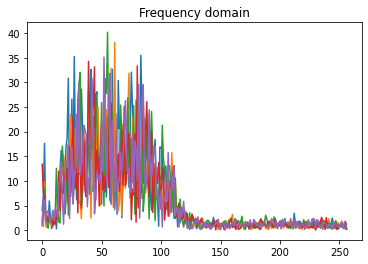

In [3]:
for i in range(5):
    plt.plot(data[i])
plt.title("Time domain")
plt.show()

for i in range(5):
    plt.plot(abs(fft.time2freq(data[i], 3.2*units.GHz)))
plt.title("Frequency domain")
plt.show()


# WGAN

In [4]:
# Create WGAN

wgan = WGAN(time_flag=True, fft_flag=True, wavelet_flag=True, mini_flag=False)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 stft (STFT)                 (None, 65, 65, 1)         0         
                                                                 
 magnitude (Magnitude)       (None, 65, 65, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 16)        160       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 32, 32, 16)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 layer_normalization (LayerN  (None, 16, 16, 32)       6

2022-09-27 10:42:11.070679: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-27 10:42:11.070710: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-27 10:42:11.070729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wgs3e.zeuthen.desy.de): /proc/driver/nvidia/version does not exist


Total params: 99,649
Trainable params: 99,649
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Train the WGAN
generator_loss, critic_loss = wgan.train(data)

Epoch:  0


2022-09-27 10:42:13.553030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 10:42:13.634935: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


KeyboardInterrupt: 

In [ ]:
# Create arrays for generator and critic loss
wgan.plot_loss(generator_loss, critic_loss)

In [ ]:
# Analyze the results
wgan.analyze_generator(data, current_noise)

In [ ]:
# # Save the models
# g.save('generator')
# critic.save('critic')

In [ ]:
# wgan.generator.save("time_fft_wavelet_generator_2")